<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/ESAA_OB_week3_hands_on_ensemble_and_randomforest_p_245_271.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 7 앙상블 학습과 랜덤 포레스트**

>앙상블 방법의 예) 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일려의 결정트리 분류기 훈련<br/>
예측을 위해 모든 개별 트리의 예측을 구한 뒤 가장 많은 선택을 받은 클래스를 예측으로 삼음<br/>
결정 트리의 앙상블을 랜덤 포레스트(random forest)라고 함.<br/>
이 장에서는 배깅, 부스팅, 스태킹 등 가장 인기 있는 앙상블 방법 공부

## **7.1 투표 기반 분류기**
---

> **직접 투표** 분류기:<br/>
여러 개의 분류기를 훈련시켜 각 분류기의 예측을 모아 가장 많이 선택된(다수결 투표) 클래스를 예측하는 분류기<br/>
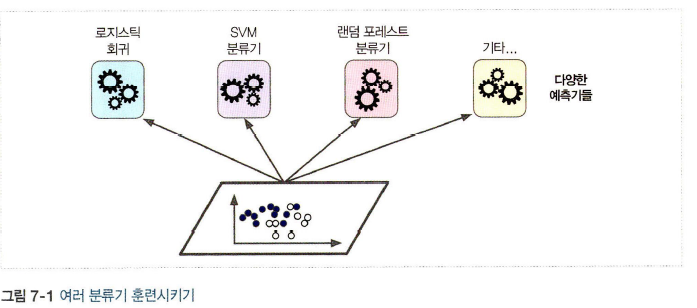<br/>
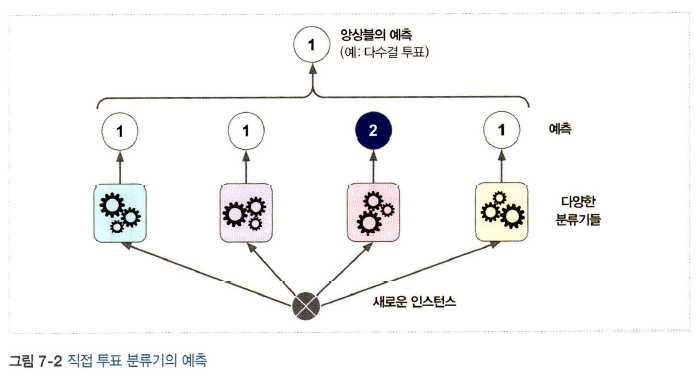

>각 분류기가 **약한 학습기**일지라도 충분하게 많고 다양하다면 앙상블은 **강한 학습기**가 될 수 있음(큰 수의 법칙)<br/>
* 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능 발휘<br/>
* 각기 다른 알고리즘으로 학습시켜야 다른 종류의 오차를 만들 가능성이 높아 앙상블 모델의 정확도 향상

In [1]:
#여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [2]:
#각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8333333333333334
RandomForestClassifier 0.9
SVC 0.9333333333333333
VotingClassifier 0.9


>**간접 투표**:<br/>
개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스 예측
* 직접 투표 방식보다 성능이 높음
* voting="hard"를 voting="soft"로 바꾸면 됨

##**7.2 배깅과 페이스팅**
---

>다양한 분류기를 만드는 또 다른 방법: 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것<br/>
**배깅**: 훈련 세트에서 중복을 허용하여 샘플링하는 방식<br/>
**페이스팅**: 중복을 허용하지 않고 샘플링하는 방식

>모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측 생성
* 수집 함수는 분류일 때는 통계적 최빈값, 회귀일 떄는 평균 계사
* 수집 함수를 통과하면 편향과 분산 모두 감소

### 7.2.1 사이킷런의 배깅과 페이스팅
---

>다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드<br/>
각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련됨

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=60, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

>[그림 7-5]는 단일 결정 트리의 결정 경계과 500개의 트리를 사용한 배깅 앙상블의 결정 경계의 비교<br/>
앙상브릐 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘됨<br/>
앙상블은 비슷한 편향에서 더 작은 분산을 만듦(훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙함)<br/>
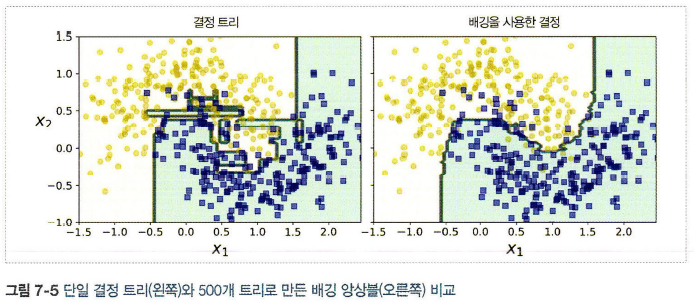

>부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음<br/>
하지만 예측기들의 상관관계가 줄어 분산은 감소

### 7.2.2 oob 평가
---

>배깅 사용 시 어떤 샘플은 여러번, 어떤 샘플은 한 번도 선택되지 않을 수 있음<br/>
oob 샘플(out-of-bag 샘플): 선택되지 않은 훈련 샘플<br/>
앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음

In [4]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9285714285714286

In [5]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)
#oob 평가 결과와 정확도 수치 매우 비슷

0.9

In [6]:
#oob_decision_function_변수에서 oob 샘플에 대한 결정 함수의 값도 확인 가능
bag_clf.oob_decision_function_

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.18579235, 0.81420765],
       [0.95721925, 0.04278075],
       [1.        , 0.        ],
       [0.95811518, 0.04188482],
       [0.7287234 , 0.2712766 ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.54255319, 0.45744681],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.25280899, 0.74719101],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99441341, 0.00558659],
       [0.84729064, 0.15270936],
       [1.        , 0.        ],
       [0.19428571, 0.80571429],
       [0.        , 1.        ],
       [0.

## **7.3 랜덤 패치와 랜덤 서브스페이스**
---

>BaggingClassifier는 특성 샘플링도 지원함<br/>
샘플링은 max_features, bootstrap_features 두 매개변수로 조절됨<br/>
작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링임<br/>
따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨<br/>
이 기법은 특히 이미지와 같은 고차원의 데이터셋을 다룰 때 유용
* **랜덤 패치 방식**: 훈련 특성과 샘플을 모두 샘플링하는 것
* **랜덤 서브스페이스 방식**: 훈련 샘플을 모두 사용하고(bootstrap=False, max_samples=1.0) 특성은 샘플링하는(bootstap_features=True 그리고/또는 max_features는 1.0보다 작게 설정)
* 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산 낮춤

## **7.4 랜덤 포레스트**
---

>랜덤 포레스트는 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블
* max_samples를 훈련 세트의 크기로 지정

In [7]:
#500개 트리로 이뤄진 랜덤포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

>랜덤 포레스트 알고리즘은 트리의 노드 분할 시 전체 특성 중 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입<br/>
이는 트리를 더 다양하게 만들고 편향을 손해보는 대신 분할을 낮춰 전체적으로 더 훌륭한 모델 생성해냄

### 7.4.1 엑스트라 트리
---

>랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용함<br/>
트리를 더욱 무작위하게 만들기 위해 보통의 결정 트리처럼 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 뒤 그 중 최상의 분할을 선택함<br/>
이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤 트리 앙상블(엑스트라 트리)**라 함
* 편향이 늘어나지만 분산은 낮춰짐
* 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 시간이 많이 소요되므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름
* 사이킷런의 ExtraTreesClassifier 사용

### 7.4.2 특성 중요도
---

>랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것<br/>
사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정<br/>
즉, 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음<br/>
사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화함

In [10]:
from sklearn.datasets import load_iris
iris=load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09280952476007338
sepal width (cm) 0.02280641111687661
petal length (cm) 0.4515139642342826
petal width (cm) 0.4328700998887674


## **7.5 부스팅**
---

> **부스팅**: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법<br/>
앞의 모델을 보완해나가면서 일련의 예측기를 학습시킴
* 가장 인기 있는 방법: <u>에이다부스트</u> & <u>그레이디언트 부스팅</u>

### 7.5.1 에이다부스트
---

>이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것<br/>
이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨<br/>
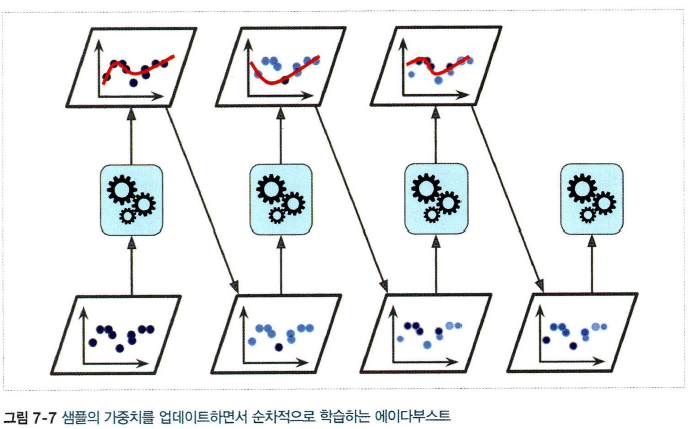

>[그림 7-8]은 moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계<br/>
* 첫번째 분류기에서 잘못 분류된 샘플들의 가중치가 높아져 두번째 분류기는 이 샘플들을 더 정확히 예측하게 됨<br/>
* 오른쪽 그래프는 학습률을 반으로 낮춘 것만 빼고 똑같은 일련의 예측기<br/>
(즉, 잘못 분류된 샘플의 가중치는 반복마다 절반 정도만 높아짐)
* 경사 하강법과 비슷한 면이 있는데, 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면, 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기 추가함<br/>
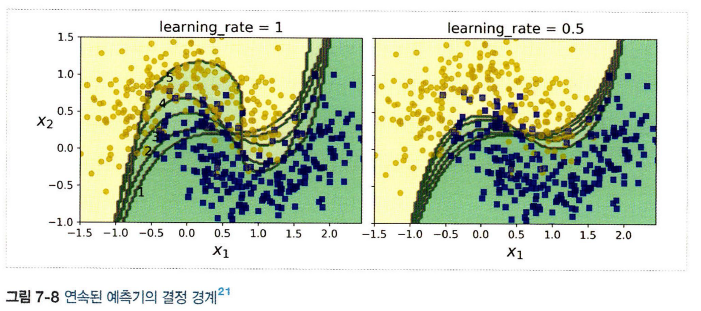

>모든 예측기가 훈련을 마치면 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듦<br/>
하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨

>**에이다부스트 알고리즘**
* 각 샘플 가중치 image.png는 초기에 image.png로 초기화 됨
* 첫 번째 예측기가 학습되고, 가중치가 적용된 에러율 image.png이 훈련 세트에 대해 계산됨<br/>
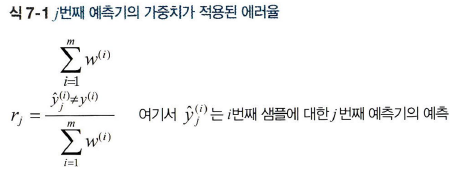

>* 예측기의 가중치 image.png는 [식 7-2]를 사용해 계산됨.
* 여기서 image.png는 학습률 하이퍼파라미터(df=1)
* 만약 무작위로 예측하는 정도라면 가중치=0(더 정확도 낮으면 음수)<br/>
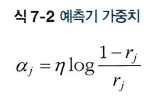

>* 이후 에이다부스트 알고리즘이 [식 7-3]을 사용해 샘플의 가중치를 업데이트함<br/>
즉, 잘못 분류된 샘플의 가중치가 증가됨<br/>
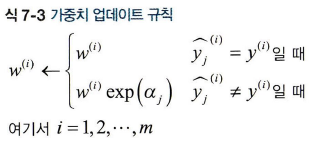

>* 이후 모든 샘플의 가중치를 정규화함(즉, 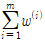으로 나눔)
* 마지막으로 새 예측기가 업데이트 된 가중치를 사용해 훈련되고 전체 과정이 반복됨.
* 이 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지됨
* 예측 시 에이다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 image.png를 더해 예측 결과를 만듦<br/>
가중치 합이 가장 큰 클래스가 예측 결과가 됨<br/>
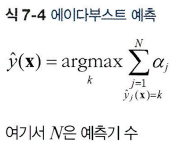

>사이킷런은 SAMME라는 에이다부스트의 다중 클래스 버전 사용

In [12]:
# 200개의 아주 얕은 결정트리를 기반으로 하는 에이다부스트 분류기 훈련
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R",learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅
---

>에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함<br/>
하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차(residual error)에 새로운 예측기를 학습시킴

In [13]:
#결정 트리를 기반 예측기로 사용하는 간단한 회귀 문제
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [14]:
# 첫번째 예측기에서 생긴 잔여 오차에 두번쨰 DecisionTreeRregressor 훈련시킴
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [15]:
#두번째 예측기가 만든 잔여 오차에 세번째 회귀 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [17]:
#이제 새 개의 트리를 포함하는 앙상블 모델 생성됨
# 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 됨
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

>[그림 7-9]의 왼쪽 열: 세 트리의 예측, 오른쪽 열: 앙상블의 예측
* 첫번째 행: 앙상블에 트리가 하나만 있으니 첫번째 트리의 예측과 완전히 같음
* 두번째 행: 오른쪽의 앙상블 예측이 두 개의 트리 예측의 합과 같음
* 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아짐<br/>
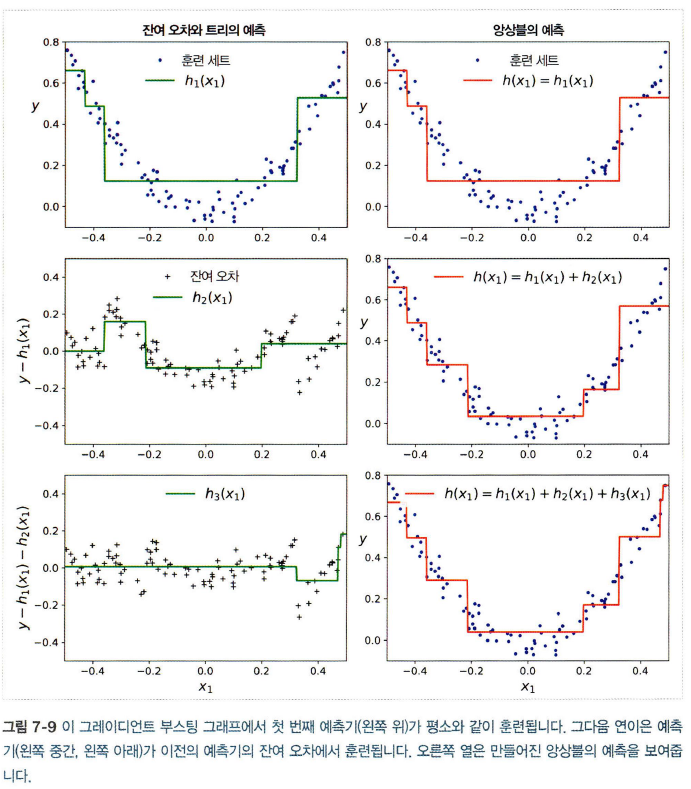

In [18]:
# 더 간단히 훈련하는 법
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

>learning_rate 매개변수가 각 트리의 기여 정도를 조절함<br/>
낮게 설정 시 많은 트리가 피료하지만 일반적으로 예측의 성능은 좋아짐 = **축소** 라고 부르는 규제 방법
* 왼쪽: 훈련 세트를 학습하기에는 트리가 충분하지 않음<br/>
오른쪽: 트리가 너무 많아 훈련 세트에 과대적합됨<br/>
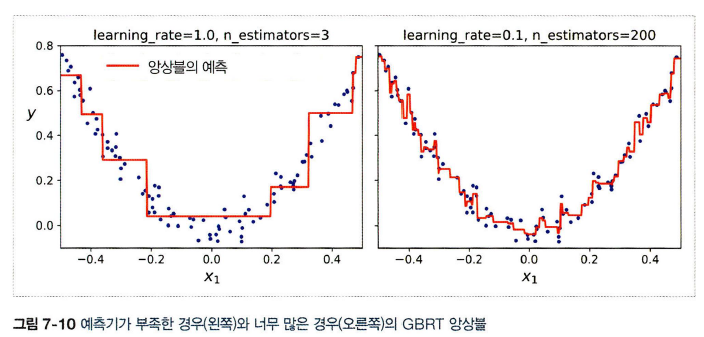

>최적의 트리 수를 찾기 위해 조기 종료 기법 사용 가능

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train,y_train)

errors=[mean_squared_error(y_val, y_pred)
        for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators=np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators = bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=118)

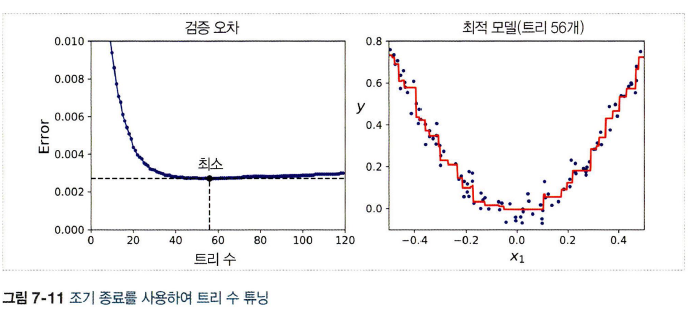

In [20]:
# 실제로 훈련을 중지하는 방법으로 조기 종료 구현 가능
gbrt =GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up=0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break   #조기 종료

>확률적 그레이디언트 부스팅:
* 각 트리가 훈련할 떄 사용할 훈련 샘플의 비율 지정(GradientBoostingRegressor의 subsample 매개변수 이용)
* subsample=0.25면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습됨
* 편향이 높아지는 대신 분산이 낮아지고 훈련 속도 높임

>XGBoost(익스트림 그레이디언트 부스팅의 약자)가 최적화된 그레이디언트 부스팅 구현으로 유명

In [21]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[06:22:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [22]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val,y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[06:22:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.462375
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.429299
[2]	validation_0-rmse:0.400366
[3]	validation_0-rmse:0.37556
[4]	validation_0-rmse:0.354452
[5]	validation_0-rmse:0.336148
[6]	validation_0-rmse:0.320633
[7]	validation_0-rmse:0.307506
[8]	validation_0-rmse:0.296339
[9]	validation_0-rmse:0.287209
[10]	validation_0-rmse:0.27931
[11]	validation_0-rmse:0.272012
[12]	validation_0-rmse:0.267003
[13]	validation_0-rmse:0.262338
[14]	validation_0-rmse:0.247357
[15]	validation_0-rmse:0.24445
[16]	validation_0-rmse:0.230327
[17]	validation_0-rmse:0.228245
[18]	validation_0-rmse:0.215784
[19]	validation_0-rmse:0.213197
[20]	validation_0-rmse:0.202203
[21]	validation_0-rmse:0.192482
[22]	validation_0-rmse:0.190171
[23]	validation_0-rmse:0.181526
[24]	validation_0-rmse:0.17389
[25]	validation_0-rmse:

## **7.6 스태킹**
---

>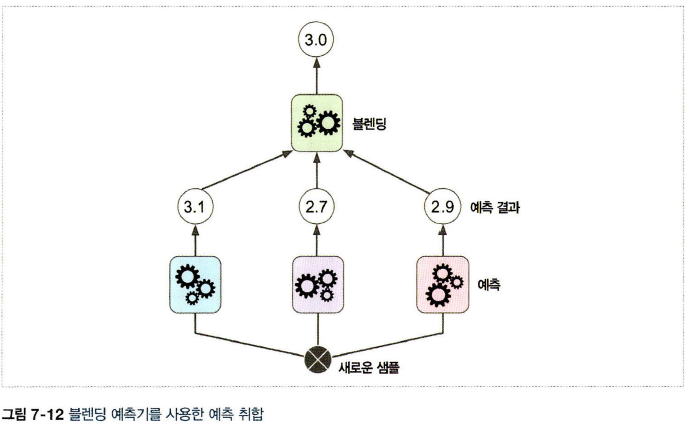

>블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 사용하는 것
1. 훈련 세트를 두 개의 서브셋으로 나눔<br/>
첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용됨<br/>
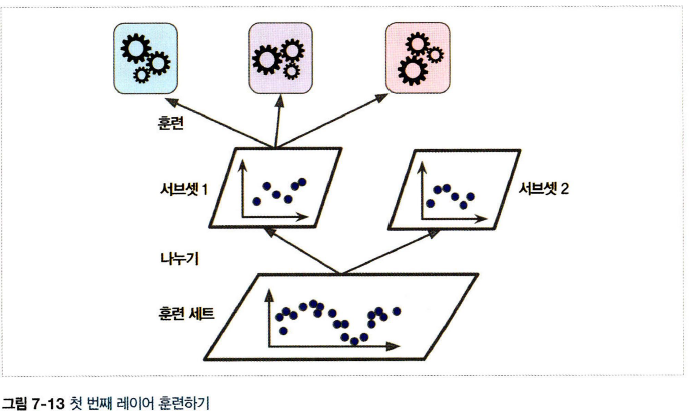

>2. 첫번째 레이어의 예측기를 사용해 두번쨰 홀드아웃 세트에 대한 예측을 생성<br/>
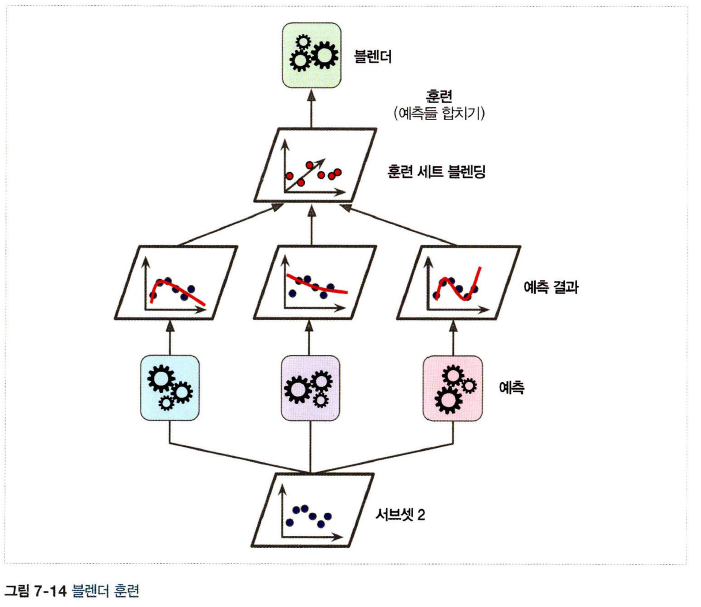

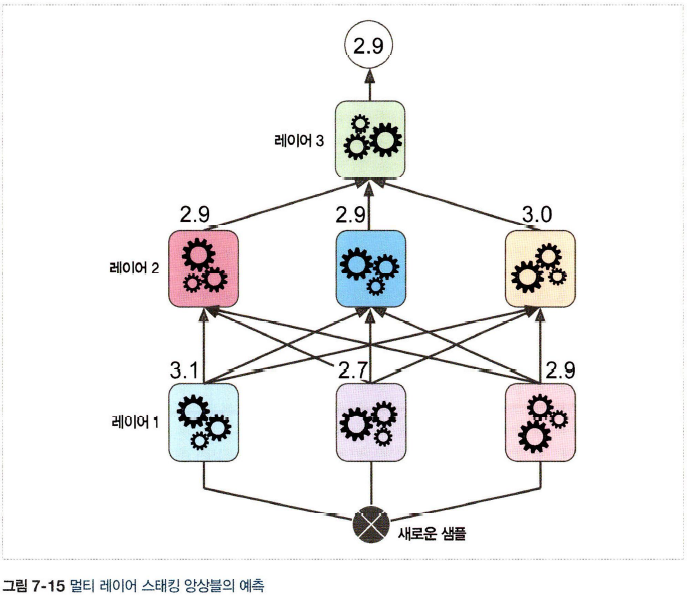

>사이킷런이 스태킹을 직접 지원하지는 않지만 직접 구현 어렵진 않음 --> 연습문제 참조